# Assignment 1 - Jack Scantlebury

### Introduction

Charged particles create an electric potential in the surrounding space. In $\mathbb{R}^2$, the potential created at $\overrightarrow p$ by $N$ particles at positions $\overrightarrow{p}_j$ with charges $k_j$ is:
$$
\begin{align}
    V(\overrightarrow{p}) &= -\sum_{j=1}^N k_j \ln{\left|\left|\overrightarrow{p} - \overrightarrow{p}_j\right|\right|_2} \\
    \text{where} \quad \overrightarrow{p} &= \begin{bmatrix}
        x\\
        y
    \end{bmatrix}
\end{align}
$$

Given a [0, 1] space in $\mathbb{R}^2$ with charges placed somewhere in that space, we can discretise into an $M \times M$ grid, and calculate the potential at each point.

### Code: Part I

The constructor of the ```PotentialGrid``` class takes many (mostly optional) parameters. Some of the more important ones are:


| Parameter(=default)     | Description   |
|:-------------:|:-------------|
| N     | Number of particles |
| grid_pts      | Grid points per dimension      |
| k_arr=-1 | List of charge values      |
| pos_arr=-1 | List of particle positions      |
| circle=False | True: Arrange particles in circle of radius 0.3, False: Random particle distribution |
| dtype='float32' | Precision. Can be 'float32' (C: float) or 'float64' (C: double) |
| opencl=True | Use OpenCL or Python (Numpy) |
| parallel=True | (Requires opencl=True) True: Use parallel kernel, False: Use 'in series' kernel |
| random_charges=False | True: Each charge has 50% chance of being +/-. False: All charges + |


If the charges and positions of the particles are left unspecified, all charges are set to +/- 1 (```random_charges=True```) or + 1 (```random_charges=False```), with positions are determined by the ```circle``` flag.

The class method ```calculate_potential_grid()``` is used to calculate the potentials at the grid points which are stored in the class variable ```grid_array```. The ```opencl``` and ```parallel``` flags in the constructor control how the potentials are calculated; ```opencl=False``` will force the use of numpy, ```opencl=True``` with ```parallel=False``` will force the use of the OpenCL kernel that uses nested for loops and ```parallel=True``` causes the class to use OpenCL with parallelism.

The parallel kernel uses a different thread and global ID for each grid point, which is extremely efficient because the number of grid points (usually) far exceeds the number of particles $N$ (comparisons can be found below the class code).

### Code: Part II

The force acting on a particle is proportional to the gradient of the potential:

$$
\begin{align}
    \overrightarrow{F}(\overrightarrow{p}_i) &= -k_i\sum^{N-1}_{j=0, j\neq i} \nabla V(\overrightarrow{p}_j)\\
    &= \sum^{N-1}_{j=0, j\neq i} k_ik_j \nabla \ln{\left|\left|\overrightarrow{p}_i - \overrightarrow{p}_j\right|\right|_2}\\
    &= \sum^{N-1}_{j=0, j\neq i} k_ik_j \nabla \ln{\sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}}\\
    &= \frac{1}{2} \sum^{N-1}_{j=0, j\neq i} k_ik_j \nabla \ln{\left[(x_i - x_j)^2 + (y_i - y_j)^2\right]}\\
    &= \frac{1}{2} \sum^{N-1}_{j=0, j\neq i} k_ik_j \cdot \begin{pmatrix}
        \frac{\partial d}{\partial x_i} \ln{\left[(x_i - x_j)^2 + (y_i - y_j)^2\right]} \\
        \frac{\partial d}{\partial y_i} \ln{\left[(x_i - x_j)^2 + (y_i - y_j)^2\right]}
    \end{pmatrix}\\
    &= \frac{1}{2} \sum^{N-1}_{j=0, j\neq i} \frac{k_ik_j}{(x_i - x_j)^2 + (y_i - y_j)^2} \cdot \begin{pmatrix}
        2(x_i - x_j) \\
        2(y_i - y_j)
    \end{pmatrix} \\
    &= \sum^{N-1}_{j=0, j\neq i} \frac{k_ik_j}{(x_i - x_j)^2 + (y_i - y_j)^2} \cdot \begin{pmatrix}
        (x_i - x_j) \\
        (y_i - y_j)
    \end{pmatrix}
\end{align}
$$

The force acting in the $x$ and $y$ directions are independent and can be calculated separately. The forces can be used to calculate the velocities $\overrightarrow{v}_i$ and therefore the particle positions at each timestep $n$:

$$
\begin{align}
    \overrightarrow{p}_i^{(n+1)} &= \overrightarrow{p}_i^{(n)} + \Delta t \overrightarrow{v}_i^{(n+1/2)} \\
    \overrightarrow{v}_i^{(n+3/2)} &= \overrightarrow{v}_i^{(n+1/2)} + \Delta t \overrightarrow{F}\left(\overrightarrow{p}_i^{(n)}\right)   
\end{align}
$$

Given $\overrightarrow{v}_i^{(0)}$ and $\overrightarrow{p}_i^{(0)}$, we must find $\overrightarrow{v}_i^{(1/2)}$. To this end, we can do one Forward Euler step:

$$
\begin{align}
    \overrightarrow{v}_i^{(1/2)} &= \overrightarrow{v}_i^{(0)} + \frac{1}{2} \Delta t \overrightarrow{F}\left(\overrightarrow{p}_i^{(0)}\right)
\end{align}
$$

We now have a viable algorithm. In the code below, there are again options for using numpy and OpenCL, in series and in parallel. However, the speed gain from parallelisation here is far smaller than for calculating the potentials, because there is one thread per particle rather than per grid point. Within each thread, there is still a substantial for loop in the calculation of the electrostatic force felt by the particle.

The ```move()``` method uses two kernels. The first calculates all of the forces by the above formula, then the new positions of the particles given their velocities, then the new particle velocities given the calculated forces and timestep specified in the function call. The second is ```calculate_potential_grid()```, which recalculates the potential under the new particle positions.

Speed tests and plots can be found below the main code.

In [2]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from mako.template import Template
from IPython.display import HTML

import matplotlib.animation as animation
import numpy as np
import pyopencl as cl
import random
import time
import os

os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'

In [3]:
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [4]:
class PotentialGrid(object):
    
    dtype = -1
    ctype = -1
    grid_arr = np.zeros((1,1))
    N = -1
    k_arr = -1
    pos_arr = -1
    grid_pts = -1
    grid_pos = []
    opencl=-1
    parallel=-1
    startup_time=-1
    device_id=-1
    forces=-1
    v0=-1
    lims=[0, 1]
    opencl=-1
    parallel=-1
    im=-1
    vhalf=-1
    max_pot=1
    move_times=[]
    
    # Generate an array of n points that form a circle of radius r
    def pts_circle(self, n, r, centre=[0,0]):
        result = []
        deg = 2*np.pi/n
        result = []
        for idx in range(n):
            x = r*np.sin(deg*idx) + centre[0]
            y = r*np.cos(deg*idx) + centre[1]
            result.append([x, y])
        return result
    
    def calculate_potential_grid(self):
        with Timer() as t:
            spacing = 1/self.grid_pts
            if not self.opencl:
                for row, _ in enumerate(self.grid_arr):
                    for col, value in enumerate(_):
                        x = col*spacing
                        y = row*spacing
                        potential = 0.0
                        for j in range(self.N):
                            xdiff = x - self.pos_arr[j][0]
                            ydiff = y - self.pos_arr[j][1]
                            if xdiff == 0 and ydiff == 0:
                                pass
                            else:
                                dist = np.linalg.norm(np.array([xdiff, ydiff]).astype(self.dtype), 2)
                                potential -= self.k_arr[j]*np.log(dist)
                        self.grid_arr[row, col] = potential
            else:
                particle_x=self.pos_arr[:, 0].astype(self.dtype)
                particle_y=self.pos_arr[:, 1].astype(self.dtype)
                particle_k=self.k_arr.astype(self.dtype)
                grid_size=np.array([self.grid_pts, self.N]).astype('int32')
                platform = cl.get_platforms()
                my_gpu_devices = platform[self.device_id].get_devices(device_type=cl.device_type.GPU)
                ctx = cl.Context(devices=my_gpu_devices)
                queue = cl.CommandQueue(ctx)
                mf = cl.mem_flags
                
                x_arr = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=particle_x)
                y_arr= cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=particle_y)
                k_arr= cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=particle_k)
                info = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=grid_size)
                if self.parallel:
                    kernel_template=Template("""
                        
                        ${ctype} norm(${ctype} x1, ${ctype} y1, ${ctype} x2, ${ctype} y2){
                            ${ctype} xdiff = x1 - x2;
                            ${ctype} ydiff = y1 - y2;
                            ${ctype} norm = sqrt(xdiff*xdiff + ydiff*ydiff);
                            return norm;
                        }
                        
                        __kernel void potential(__global const ${ctype} *x_arr,
                                          __global ${ctype} *y_arr, __global ${ctype} *k_arr,
                                          __global int *info, __global ${ctype} *potentials){
                                
                                const int idx = get_global_id(0);
                
                                const int npoints = info[0];
                                const ${ctype} spacing = 1/(${ctype})(info[0]);
                                
                                const ${ctype} y_pos = spacing*idx / npoints;
                                const ${ctype} x_pos = spacing*(idx % npoints);
                                
                                const int N = info[1];
                                
                                ${ctype} acc = 0.0;
                                
                                for(int j = 0; j < N; j++){
                                    ${ctype} n = norm(x_pos, y_pos, x_arr[j], y_arr[j]);
                                    acc = acc - k_arr[j]*log(n);
                                }
                                
                                potentials[idx] = acc;
                                
                            }
                        """)
                else:
                    kernel_template=Template("""
                        
                        ${ctype} norm(${ctype} x1, ${ctype} y1, ${ctype} x2, ${ctype} y2){
                            ${ctype} xdiff = x1 - x2;
                            ${ctype} ydiff = y1 - y2;
                            ${ctype} norm = sqrt(xdiff*xdiff + ydiff*ydiff);
                            return norm;
                        }
                        
                        __kernel void potential(__global const ${ctype} *x_arr,
                                          __global ${ctype} *y_arr, __global ${ctype} *k_arr,
                                          __global int *info, __global ${ctype} *potentials){
                        
                                const int npoints = info[0];
                                const ${ctype} spacing = 1/(${ctype})(info[0]);
                                
                                const int N = info[1];
                                
                                const int len = npoints*npoints;
                                
                                for(int idx=0; idx<len; idx++){
                                    const ${ctype} y_pos = spacing*idx / npoints;
                                    const ${ctype} x_pos = spacing*(idx % npoints);
    
                                    ${ctype} acc = 0.0;
                                    for(int j = 0; j < N; j++){
                                        ${ctype} n = norm(x_pos, y_pos, x_arr[j], y_arr[j]);
                                        acc = acc - k_arr[j]*log(n);
                                    }
                                    potentials[idx] = acc;
                                }
                            }
                        """)
                kernel = kernel_template.render(ctype=self.ctype) # Templating
                prg = cl.Program(ctx, kernel).build()
                
                size_array = np.zeros((self.grid_pts**2, 1), dtype=self.dtype)
                potential_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, size_array.nbytes)
                if self.parallel:
                    prg.potential(queue, (self.grid_pts**2, ), None, x_arr, y_arr,
                                  k_arr, info, potential_buffer)
                else:
                    prg.potential(queue, (1, ), None, x_arr, y_arr,
                                  k_arr, info, potential_buffer)
                self.grid_arr = np.zeros((self.grid_pts**2), dtype=self.dtype)
                cl.enqueue_copy(queue, self.grid_arr, potential_buffer)
                self.grid_arr = self.grid_arr.reshape(self.grid_pts, self.grid_pts)
        self.startup_time = t.interval
        return self.grid_arr
    
    def __init__(self, N, grid_pts, k_arr=-1, pos_arr=-1, circle=False, dtype='float32',
                 opencl=True, parallel=True, device_id=0, v0=-1, random_charges=False):
        with Timer() as t:
            self.dtype = dtype
            self.grid_arr = np.zeros((grid_pts, grid_pts), dtype=self.dtype)
            self.grid_pos = self.grid_arr
            self.grid_pts = grid_pts
            self.opencl=opencl
            self.parallel=parallel
            self.N=N
            self.device_id=device_id
            self.forces = np.zeros((N, 2)).astype(dtype)
            self.opencl=opencl
            self.parallel=parallel
            self.dtype=dtype
            if v0==-1:
                self.v0=np.zeros((N, 2)).astype(dtype)
            if dtype == 'float32':
                self.ctype = 'float'
            else:
                self.ctype = 'double'
            if circle:
                self.k_arr = 1*np.ones((N, 1)).astype(dtype)
                if random_charges:
                    for idx, i in enumerate(self.k_arr):
                        if random.uniform(0, 1) > 0.5:
                            self.k_arr[idx] = -self.k_arr[idx]
                self.pos_arr = np.array(self.pts_circle(N, 0.3, [0.5, 0.5]))
            elif k_arr == -1 and pos_arr == -1:
                k = []
                pos = []
                for j in range(N):
                    pos_pt = np.array([random.uniform(0, 1), random.uniform(0, 1)])
                    pos.append(pos_pt)
                    #k.append(random.uniform(0, 1))
                    if random.uniform(0, 1) < 0.5 or not random_charges:
                        k.append(1)
                    else:
                        k.append(-1)
                self.k_arr = np.array(k).astype(dtype)
                self.pos_arr = np.array(pos).astype(dtype)
                for idx, i in enumerate(self.k_arr):
                    if random.uniform(0,1) > 0.5:
                        self.k_arr[idx] = -self.k_arr[idx]
            else:
                self.pos_arr = np.zeros((len(pos_arr), 2))
                for i in range(len(self.pos_arr)):
                    self.pos_arr[i, 0] = pos_arr[i][0]
                    self.pos_arr[i, 1] = pos_arr[i][1]
                self.k_arr = np.array(k_arr).reshape(len(k_arr), 1)
            self.calculate_potential_grid()
        self.startup_time = t.interval
        
    def calculate_force(self, pt, k_pt, x, y, k, n):
        Fx = 0.0
        Fy = 0.0
        for j in range(len(x)):
            if j != n:
                premul = k_pt*k[j]/((pt[0] - x[j])**2 + (pt[1] - y[j])**2)
                Fx += (pt[0] - x[j])*premul
                Fy += (pt[1] - y[j])*premul
        result = np.zeros((1, 2))
        result[0, 0] = Fx
        result[0, 1] = Fy
        return result
    
    def all_forces(self):
        for item in range(len(self.k_arr)):
            self.forces[item, :] = self.calculate_force(self.pos_arr[item],
                                                        self.k_arr[item],
                                                   self.pos_arr[:, 0],
                                                   self.pos_arr[:, 1],
                                                   self.k_arr, item)
    def move(self, delta_t, opencl, parallel):
        if not opencl:
            with Timer() as t:
                self.all_forces()
                if type(self.vhalf) == int:
                    self.vhalf = 0.5*delta_t*self.forces
                self.pos_arr = self.pos_arr + delta_t*self.vhalf
                self.vhalf = self.vhalf + delta_t*self.forces
                self.calculate_potential_grid()
            self.move_times.append(t.interval)
        else:
            with Timer() as t:
                vhalf_zero_flag = -1
                if type(self.vhalf) == int:
                    vhalf_zero_flag = 1
                    self.vhalf=np.zeros((self.N, 2))
                spacing = 1/self.grid_pts
                particle_x=self.pos_arr[:, 0].astype(self.dtype)
                particle_y=self.pos_arr[:, 1].astype(self.dtype)
                particle_k=self.k_arr.astype(self.dtype)
                particle_vx=self.vhalf[:, 0].astype(self.dtype)
                particle_vy=self.vhalf[:, 1].astype(self.dtype)
                other_info=np.array([self.grid_pts, self.N, delta_t, vhalf_zero_flag]).astype(self.dtype)
                platform = cl.get_platforms()
                my_gpu_devices = platform[self.device_id].get_devices(device_type=cl.device_type.GPU)
                ctx = cl.Context(devices=my_gpu_devices)
                queue = cl.CommandQueue(ctx)
                mf = cl.mem_flags

                x_arr = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=particle_x)
                y_arr = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=particle_y)
                k_arr = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                       hostbuf=particle_k)
                vx_arr = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=particle_vx)
                vy_arr = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                       hostbuf=particle_vy)
                info = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                       hostbuf=other_info)
                
                if parallel:
                    kernel_template=Template("""

                        ${ctype} norm(${ctype} x1, ${ctype} y1, ${ctype} x2, ${ctype} y2){
                            ${ctype} xdiff = x1 - x2;
                            ${ctype} ydiff = y1 - y2;
                            ${ctype} norm = sqrt(xdiff*xdiff + ydiff*ydiff);
                            return norm;
                        }

                        __kernel void move(__global ${ctype} *x_arr,
                                          __global ${ctype} *y_arr, __global ${ctype} const *k_arr,
                                          __global ${ctype} *vx_arr, __global ${ctype} *vy_arr,
                                          __global ${ctype} const *info,
                                          __global ${ctype} *Fx, __global ${ctype} *Fy){
                                          
                                const int global_id = get_global_id(0);

                                const int npoints = (int)info[0];
                                const int N = (int)info[1];
                                const ${ctype} dt = (${ctype})info[2];
                                const ${ctype} spacing = 1/(${ctype})(info[0]);
                                const int len = npoints*npoints;

                                ${ctype} fx = 0;
                                ${ctype} fy = 0;
                                ${ctype} x1 = x_arr[global_id];
                                ${ctype} y1 = y_arr[global_id];
                                ${ctype} k_pt = k_arr[global_id];
                                
                                for(int j=0; j<N; j++){
                                    const ${ctype} x2 = x_arr[j];
                                    const ${ctype} y2 = y_arr[j];
                                    if(j != global_id){
                                        const ${ctype} premul = k_pt*k_arr[j]/((x1 - x2)*(x1 - x2) + (y1 - y2)*(y1 - y2));
                                        fx = fx + (x1 - x2)*premul;
                                        fy = fy + (y1 - y2)*premul;
                                    }
                                }
                                
                                Fx[global_id] = fx;
                                Fy[global_id] = fy;

                                if(info[3] > 0){
                                    vx_arr[global_id] = 0.5*dt*Fx[global_id];
                                    vy_arr[global_id] = 0.5*dt*Fy[global_id];
                                }

                                x_arr[global_id] = x_arr[global_id] + dt*vx_arr[global_id];
                                y_arr[global_id] = y_arr[global_id] + dt*vy_arr[global_id];
                                vx_arr[global_id] = vx_arr[global_id] + dt*Fx[global_id];
                                vy_arr[global_id] = vy_arr[global_id] + dt*Fy[global_id];
                            }
                        """)
                else:
                    kernel_template=Template("""

                        ${ctype} norm(${ctype} x1, ${ctype} y1, ${ctype} x2, ${ctype} y2){
                            ${ctype} xdiff = x1 - x2;
                            ${ctype} ydiff = y1 - y2;
                            ${ctype} norm = sqrt(xdiff*xdiff + ydiff*ydiff);
                            return norm;
                        }

                        __kernel void move(__global ${ctype} *x_arr,
                                          __global ${ctype} *y_arr, __global ${ctype} const *k_arr,
                                          __global ${ctype} *vx_arr, __global ${ctype} *vy_arr,
                                          __global ${ctype} const *info, __global ${ctype} *potentials,
                                          __global ${ctype} *Fx, __global ${ctype} *Fy){

                                

                                const int npoints = (int)info[0];
                                const int N = (int)info[1];
                                const ${ctype} dt = (${ctype})info[2];
                                const ${ctype} spacing = 1/(${ctype})(info[0]);
                                const int len = npoints*npoints;

                                for(int n=0; n<N; n++){
                                    ${ctype} fx = 0;
                                    ${ctype} fy = 0;
                                    ${ctype} x1 = x_arr[n];
                                    ${ctype} y1 = y_arr[n];
                                    ${ctype} k_pt = k_arr[n];
                                    for(int j=0; j<N; j++){
                                        const ${ctype} x2 = x_arr[j];
                                        const ${ctype} y2 = y_arr[j];
                                        j != n:
                                            const ${ctype} premul = k_pt*k_arr[j]/((x1 - x2)*(x1 - x2) + (y1 - y2)*(y1 - y2));
                                            fx = fx + (x1 - x2)*premul;
                                            fy = fy + (y1 - y2)*premul;
                                        }
                                    }
                                    Fx[n] = fx;
                                    Fy[n] = fy;
                                }

                                if(info[3] > 0){
                                    for(int idx=0; idx<N; idx++){
                                        vx_arr[idx] = 0.5*dt*Fx[idx];
                                        vy_arr[idx] = 0.5*dt*Fy[idx];
                                    }
                                }

                                for(int idx=0; idx<N; idx++){
                                    x_arr[idx] = x_arr[idx] + dt*vx_arr[idx];
                                    y_arr[idx] = y_arr[idx] + dt*vy_arr[idx];
                                }

                                for(int idx=0; idx<N; idx++){
                                    vx_arr[idx] = vx_arr[idx] + dt*Fx[idx];
                                    vy_arr[idx] = vy_arr[idx] + dt*Fy[idx];
                                }

                                for(int idx=0; idx<len; idx++){
                                    const ${ctype} y_pos = spacing*idx / npoints;
                                    const ${ctype} x_pos = spacing*(idx % npoints);

                                    ${ctype} acc = 0.0;
                                    for(int j = 0; j < N; j++){
                                        ${ctype} n = norm(x_pos, y_pos, x_arr[j], y_arr[j]);
                                        acc = acc - k_arr[j]*log(n);
                                    }
                                    potentials[idx] = acc;
                                }
                            }
                        """)
                kernel = kernel_template.render(ctype=self.ctype, len=str(self.N)) # Templating
                prg = cl.Program(ctx, kernel).build()

                size_array = np.zeros((self.N, 1), dtype=self.dtype)

                if not parallel:
                    potential_size_array = np.zeros((self.grid_pts**2, 1), dtype=self.dtype)
                    potential_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, potential_size_array.nbytes)
                    
                fx_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, size_array.nbytes)
                fy_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, size_array.nbytes)

                if parallel:
                    prg.move(queue, (self.N, ), (1, ), x_arr, y_arr, k_arr, vx_arr, vy_arr, info,
                            fx_buffer, fy_buffer)
                else:
                    prg.move(queue, (1, ), None, x_arr, y_arr, k_arr, vx_arr, vy_arr, info, potential_buffer,
                             fx_buffer, fy_buffer)
                    self.grid_arr = np.zeros((self.grid_pts**2), dtype=self.dtype)
                    
                x = np.empty_like(self.pos_arr[:, 0]).astype(self.dtype)
                y = np.empty_like(self.pos_arr[:, 0]).astype(self.dtype)
                vx = np.empty_like(self.vhalf[:, 0]).astype(self.dtype)
                vy = np.empty_like(self.vhalf[:, 0]).astype(self.dtype)
                #fx = np.empty_like(self.vhalf[:, 0]).astype(self.dtype)
                #fy = np.empty_like(self.vhalf[:, 0]).astype(self.dtype)
                if not parallel:
                    cl.enqueue_copy(queue, self.grid_arr, potential_buffer)

                cl.enqueue_copy(queue, x, x_arr)
                cl.enqueue_copy(queue, y, y_arr)
                cl.enqueue_copy(queue, vx, vx_arr)
                cl.enqueue_copy(queue, vy, vy_arr)
                #cl.enqueue_copy(queue, fx, fx_buffer)
                #cl.enqueue_copy(queue, fy, fy_buffer)

                self.pos_arr[:, 0] = x
                self.pos_arr[:, 1] = y
                self.vhalf[:, 0] = vx
                self.vhalf[:, 1] = vy
                if not parallel:
                    self.grid_arr = self.grid_arr.reshape(self.grid_pts, self.grid_pts)
                else:
                    self.calculate_potential_grid()
            self.move_times.append(t.interval)
        
    @property
    def grid(self):
        return self.grid_arr
    
    def potential_at(self, x, y):
        return self.grid_arr[x, y]

    def show_potential(self, plot_charges=True):
        fig, ax = plt.subplots()
        plt.imshow(self.grid_arr/np.amax(self.grid_arr),
                   )      #cmap='gray'   
        max_k = np.amax(self.k_arr)
        if plot_charges:
            for idx, point in enumerate(self.pos_arr):
                size = 5*self.k_arr[idx]/max_k
                plt.plot(point[0]*self.grid_pts, point[1]*self.grid_pts, 'w-+',
                         markersize=size)
        
        ax.yaxis.set_major_locator(plt.NullLocator())
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(r'$x$')
        plt.ylabel(r'$y$')
        cps = (self.N*self.grid_pts**2)/self.startup_time
        if self.opencl:
            if self.parallel:
                titlestr = ('N = ' + str(len(self.k_arr)) + ' | Grid Points = '
                            + str(self.grid_pts) + '\nOpenCL | Parallel | ' + str(self.device_id) + '\n' +
                            '%.3e' % cps + ' calculations per second')
            else:
                titlestr = ('N = ' + str(len(self.k_arr)) +
                            ' | Grid Points = ' + str(self.grid_pts) +
                            '\nOpanCL | Non-Parallel | ' + str(self.device_id) + '\n' + '%.3e' % cps +
                            ' calculations/s')
        else:            
            titlestr = ('N = ' + str(len(self.k_arr)) + ' | Grid Points = ' +
                        str(self.grid_pts) + '\nPython | ' + str(self.device_id) + '\n' + '%.3e' % cps +
                        ' calculations s')
        plt.title(titlestr)
        plt.show()

### Results: Part I

The ```show_potential()``` method uses ```matplotlib``` to visualise the current potential at each grid point:

In [12]:
grid_1 = PotentialGrid(10, 100, dtype='float32', circle=True, opencl=True,
                     parallel=False, random_charges=False)

grid_1.show_potential(plot_charges=True)

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x18edb64b0f0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


The calculations per second is shown above the plot. The time taken to calculate the potentials on the entire grid is recorded in the class variable ```startup_time```. The calculations per second $c$ is taken to be:

$$
\begin{align}
    c = \frac{Nm^2}{t}
\end{align}
$$

where $N$ is the number of particles, $m$ is the grid points per dimension and $t$ is the calculation time in seconds. We can see an enormous difference between the different calculation methods (Python, OpenCL, (non)-parallel):

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x1e9f4126830> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


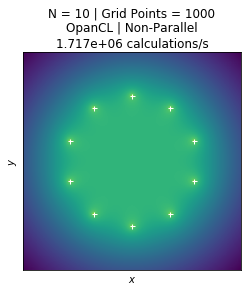

In [73]:
grid_series = PotentialGrid(10, 1000, dtype='float32', circle=True, 
                     parallel=False, random_charges=False)
grid_series.show_potential()


In [29]:
def dynamic(N, resolution, dtype, circle, opencl, parallel, time_step, frames, random_charges):
    grid = PotentialGrid(N, resolution, dtype=dtype, circle=circle, opencl=True,
                     parallel=parallel, device_id=0, random_charges=random_charges)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    v = abs(np.amax(grid.grid_arr))
    if random_charges:
        line = plt.imshow(np.zeros((grid.N, grid.N)), vmin=-v, vmax=v, cmap='bwr')
    else:
        line = plt.imshow(np.zeros((grid.N, grid.N)), vmin=0, vmax=v, cmap='bwr')
    cbar = plt.colorbar()
    cbar.set_label('Charge',size=18)
    
    def init():
        line.set_data(grid.grid_arr)
        return (line, )

    def animate(i):
        s = ' '*(5-len(str(i+1)))
        sys.stdout.write("\rTrial" + s + str(i+1))
        sys.stdout.flush()
        grid.move(time_step, opencl=opencl, parallel=parallel)
        line.set_array(grid.calculate_potential_grid())
        return(line, )

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=50, blit=True)
    return anim

HTML(dynamic(N=10, resolution=1000, dtype='float32', circle=False, opencl=True, parallel=True,
             time_step=0.008, frames=50, random_charges=True).to_html5_video())

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x1e9f4126830> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Trial   50